In [23]:
# Import the dependencies
import numpy as np
from scipy.linalg import toeplitz, cholesky, sqrtm, inv
# import scipy.linalg as la
from scipy import signal
from scipy.integrate import odeint
import time
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")
print("Imports done")


Imports done


In [24]:
def g_gp(x,v):

    t0=25
    return t0 -16 / (1 + np.exp(5-x/5))

def dg_gp(x):
    
    return -16/5* np.exp(5-x/5) / (np.exp(5-x/5)+1)**2

# # Show the temperature curve
# x_show = np.arange (-0,50,0.01)
# y_show = g_gp(x_show,0)
# dy_show = dg_gp(x_show)
# plt.plot(y_show, x_show)
# #plt.plot(dy_show, x_show)
# plt.ylabel('Depth (centimeters)')
# plt.xlabel('Temperature (° C)')
# plt.gca().invert_yaxis()
# plt.vlines(17, 50, 25, colors='r', linestyles='dashed')
# plt.hlines(25, 10,17, colors='r', linestyles='dashed')
# plt.text(17.3,27,"Optimal temparature 17° C")
# plt.show;

# print('Temperature at 25 centimetres is: ', g_gp(25,0), ' degrees celsius')

In [25]:
print(g_gp(30,30))
print(g_gp(25,30))

13.303062741919922
17.0


In [59]:
# Setting up the time data:
dt = 0.005; # integration step, average neuron resets 200 times per second
T = 5+dt; # maximum time considered
t = np.arange(0,T,dt)
N= t.size #Amount of data points


In [27]:
def makeNoise(C,s2,t):
    
    if np.size(C)== 1:
        n = 1
    else:
        n = C.shape[1]  # dimension of noise
        
    # Create the white noise with correct covariance
    N = np.size(t)      # number of elements
    L =cholesky(C, lower=True)  #Cholesky method
    w = np.dot(L,np.random.randn(n,N))
    
    if s2 <= 1e-5: # return white noise
        return w
    else: 
        # Create the noise with temporal smoothness
        P = toeplitz(np.exp(-t**2/(2*s2)))
        F = np.diag(1./np.sqrt(np.diag(np.dot(P.T,P))))
        K = np.dot(P,F)
        ws = np.dot(w,K)
        return ws

In [28]:
class ai_capsule():

    def __init__(self,dt, mu_v, Sigma_w, Sigma_z, a_mu):   
        self.dt = dt    # integration step
        self.mu_x = mu_v   # initializing the best guess of hidden state by the hierarchical prior
        self.F = 0      # Free Energy
        self.eps_x = 0  # epsilon_x, prediction error on hidden state
        self.eps_y = 0  # epsilon_y, prediction error on sensory measurement
        self.Sigma_w = Sigma_w #Estimated variance of the hidden state 
        self.Sigma_z = Sigma_z # Estimated variance of the sensory observation 
        self.alpha_mu = a_mu # Learning rate of the gradient descent mu (hidden state)
        self.plot_dict = {"eps_x": [], "eps_y": [],"dprec_w": [],"dprec_z": []}
    
    def g(self,x,v):

        return g_gp(x,v)
    
    def dg(self, x):

        return dg_gp(x)
    
    def f(self,x,v):

        return v
    

        
    def inference_step (self, i, mu_v, y):


        # Calculate prediction errors
        self.eps_x = self.mu_x - self.f(self.mu_x, mu_v)  # prediction error hidden state
        self.eps_y = y - self.g(self.mu_x, mu_v) #prediction error sensory observation
        # Free energy gradient
        dFdmu_x = self.eps_x/self.Sigma_w - self.dg(self.mu_x) * self.eps_y/self.Sigma_z
        # Perception dynamics
        dmu_x   = 0 - self.alpha_mu*dFdmu_x  # Note that this is an example without generalised coordinates of motion hence u'=0
        # motion of mu_x 
        self.mu_x = self.mu_x + self.dt * dmu_x
        
       
        #motion of sigma's
        
        # Derivati w.r.t. precision
        dprec_w = -0.5*(self.eps_x**2-self.Sigma_w)
        dprec_z = -0.5*(self.eps_y**2-self.Sigma_z)
        
        #sigma update scheme
#         self.Sigma_w = self.Sigma_w + self.dt* dSigma_w 
#         self.Sigma_z = self.Sigma_z + self.dt* dSigma_z
        
        #precision update scheme
        prec_w = 1/self.Sigma_w
        prec_z = 1/self.Sigma_z
        
        prec_w = prec_w +self.dt*dprec_w
        prec_z = prec_z +self.dt*dprec_z
        
        self.Sigma_w = 1/prec_w
        self.Sigma_z = 1/prec_z
        #invert back to variance
        
        
#         print(self.Sigma_w)
#         print(self.Sigma_z)
        #Calculate Free Energy to report out
        self.F = 0.5 * (self.eps_x**2 / self.Sigma_w + self.eps_y**2 / self.Sigma_z + np.log(self.Sigma_w * self.Sigma_z))
        #gather data from prediction error 
        self.plot_dict["eps_x"].append(self.eps_x)
        self.plot_dict["eps_y"].append(self.eps_y)
        self.plot_dict["dprec_w"].append(dprec_w)
        self.plot_dict["dprec_z"].append(dprec_z)
        return self.F, self.mu_x , self.g(self.mu_x,0), self.Sigma_w, self.Sigma_z 

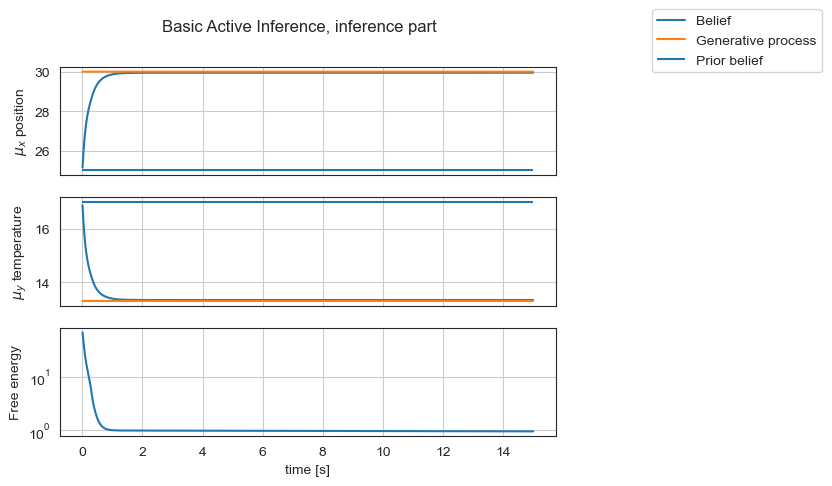

In [29]:
def simulation (v, mu_v, Sigma_w, Sigma_z, noise, a_mu):
    
    # Init tracking
    mu_x = np.zeros(N) # Belief or estimation of hidden state 
    F = np.zeros(N) # Free Energy of AI neuron
    mu_y = np.zeros(N) # Belief or prediction of sensory signal
    x = np.zeros(N) # True hidden state
    y = np.zeros(N) # Sensory signal as input to AI neuron
    vSigma_w = np.zeros(N) #Value for variance
    vSigma_z = np.zeros(N)

    # Create active inference neuron
    capsule = ai_capsule(dt, mu_v, Sigma_w, Sigma_z, a_mu)  

    # Construct noise signals with emporal smoothness:
    np.random.seed(42)
    sigma = 1/2000 # smoothness of the noise parameter, variance of the filter
    w = makeNoise(Sigma_w,sigma,t)
    z = makeNoise(Sigma_z,sigma,t)

    ssim = time.time() # start sim
    
    # Simulation
    for i in np.arange(1,N):
        # Generative process
        if noise == 'white':
            x[i] = v + np.random.randn(1)* Sigma_w
            y[i] = g_gp(x[i],v) + np.random.randn(1)* Sigma_z
        elif noise == 'smooth':
            x[i]= v + w[0,i]
            y[i] = g_gp(x[i],v) + z[0,i]
        else: #no noise
            x[i]= v 
            y[i] = g_gp(x[i],v)
        #Active inference
        F[i], mu_x[i], mu_y[i], vSigma_w[i], vSigma_z[i]= capsule.inference_step(i,mu_v,y[i])

       

    # Print the results
    plot_dict = capsule.plot_dict
    tsim = time.time() - ssim
    #print('Simulation time: ' + "%.2f" % tsim + ' sec' )

    return F, mu_x, mu_y, x, y, vSigma_w, vSigma_z, plot_dict

# Test case

v = 30 # actual depth Hydar
mu_v = 25 # Hydars belief of the depth
F1, mu_x1, mu_y1, x1, y1, vSigma_w, vSigma_z ,plot_dict= simulation(v,mu_v,1,0.1,'no noise',1) # prior and observation balanced, both variance of 1



# Plot results:
fig, axes = plt.subplots(3, 1, sharex='col');
fig.suptitle('Basic Active Inference, inference part');
axes[0].plot(t[1:],mu_x1[1:],label='Belief');
axes[0].plot(t[1:],x1[1:],label='Generative process');
axes[0].hlines(mu_v, 0,T, label='Prior belief')
axes[0].set_ylabel('$\mu_x$ position');
fig.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
axes[0].grid(1);
axes[1].plot(t[1:],mu_y1[1:],label='Belief');
axes[1].plot(t[1:],y1[1:],label='Generative process');
axes[1].hlines(g_gp(mu_v,0), 0,T, label='Prior belief')
axes[1].set_ylabel('$\mu_y$ temperature');
axes[1].grid(1);
axes[2].semilogy(t[1:],F1[1:],label='Belief');
axes[2].set_xlabel('time [s]');
axes[2].set_ylabel('Free energy');
axes[2].grid(1);





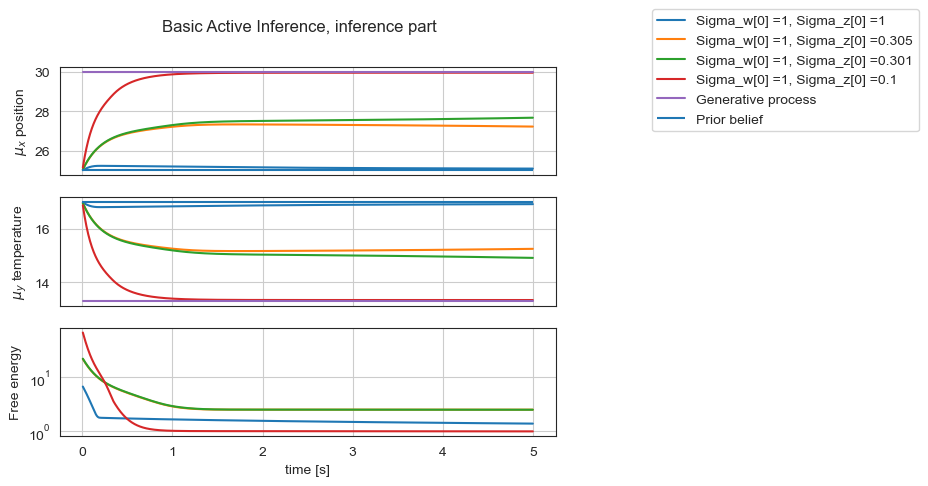

In [60]:
v = 30 # actual depth Hydar
mu_v = 25 # Hydars belief of the depth
F1, mu_x1, mu_y1, x1, y1, vSigma_w1, vSigma_z1, plot_dict1 = simulation(v,mu_v,1,1,'no noise',1) # prior and observation balanced
F2, mu_x2, mu_y2, x2, y2, vSigma_w2, vSigma_z2, plot_dict2 = simulation(v,mu_v,1,0.305,'no noise',1) # underctain about prior
F3, mu_x3, mu_y3, x3, y3, vSigma_w3, vSigma_z3, plot_dict3 = simulation(v,mu_v,1,0.301,'no noise',1) # Trust generative model, belief high variance in sensor
F4, mu_x4, mu_y4, x4, y4, vSigma_w4, vSigma_z4,  plot_dict4 = simulation(v,mu_v,1,0.1,'no noise',1) # Trust generative model, belief high variance in sensor

# Plot results of different converences of belierf:
fig, axes = plt.subplots(3, 1, sharex='col');
fig.suptitle('Basic Active Inference, inference part');
axes[0].plot(t[1:],mu_x1[1:],label='Sigma_w[0] =1, Sigma_z[0] =1');
axes[0].plot(t[1:],mu_x2[1:],label='Sigma_w[0] =1, Sigma_z[0] =0.305');
axes[0].plot(t[1:],mu_x3[1:],label='Sigma_w[0] =1, Sigma_z[0] =0.301');
axes[0].plot(t[1:],mu_x4[1:],label='Sigma_w[0] =1, Sigma_z[0] =0.1');
axes[0].plot(t[1:],x1[1:],label='Generative process');
axes[0].hlines(mu_v, 0,T, label='Prior belief')
axes[0].set_ylabel('$\mu_x$ position');
axes[0].grid(1);
fig.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
axes[1].plot(t[1:],mu_y1[1:],label='Sigma_w[0] =1, Sigma_z[0] =1');
axes[1].plot(t[1:],mu_y2[1:],label='Sigma_w[0] =1, Sigma_z[0] =0.305');
axes[1].plot(t[1:],mu_y3[1:],label='Sigma_w[0] =1, Sigma_z[0] =0.301');
axes[1].plot(t[1:],mu_y4[1:],label='Sigma_w[0] =1, Sigma_z[0] =0.1')
axes[1].plot(t[1:],y1[1:],label='Generative process');
axes[1].hlines(g_gp(mu_v,0), 0,T, label='Prior belief')
axes[1].set_ylabel('$\mu_y$ temperature');
#axes[1].legend(loc='upper right');
axes[1].grid(1);
axes[2].semilogy(t[1:],F1[1:],label='Sigma_w[0] =1, Sigma_z[0] =1');
axes[2].semilogy(t[1:],F2[1:],label='Sigma_w[0] =1, Sigma_z[0] =0.305');
axes[2].semilogy(t[1:],F3[1:],label='Sigma_w[0] =1, Sigma_z[0] =0.301');
axes[2].semilogy(t[1:],F4[1:],label='Sigma_w[0] =1, Sigma_z[0] =0.1');
axes[2].set_xlabel('time [s]');
axes[2].set_ylabel;
axes[2].set_ylabel('Free energy');
axes[2].grid(1);

In [62]:
#Unpacking plot dict and squaring prediciton errors.  
eps_y1 = plot_dict1["eps_y"]
eps_y1_squared = np.square(eps_y1)
eps_x1 = plot_dict1["eps_x"]
eps_x1_squared = np.square(eps_x1)

eps_y2 = plot_dict2["eps_y"]
eps_y2_squared = np.square(eps_y2)
eps_x2 = plot_dict2["eps_x"]
eps_x2_squared = np.square(eps_x2)

eps_y3 = plot_dict3["eps_y"]
eps_y3_squared = np.square(eps_y3)
eps_x3 = plot_dict3["eps_x"]
eps_x3_squared = np.square(eps_x3)

eps_y4 = plot_dict4["eps_y"]
eps_y4_squared = np.square(eps_y4)
eps_x4 = plot_dict4["eps_x"]
eps_x4_squared = np.square(eps_x4)


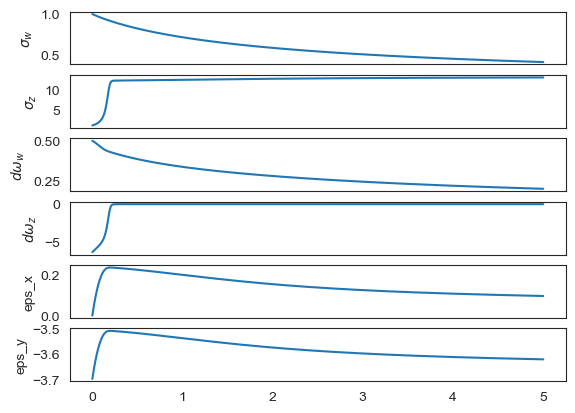

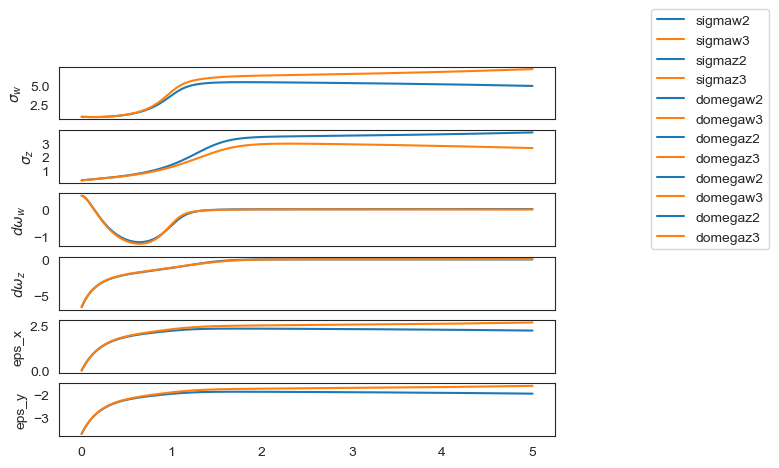

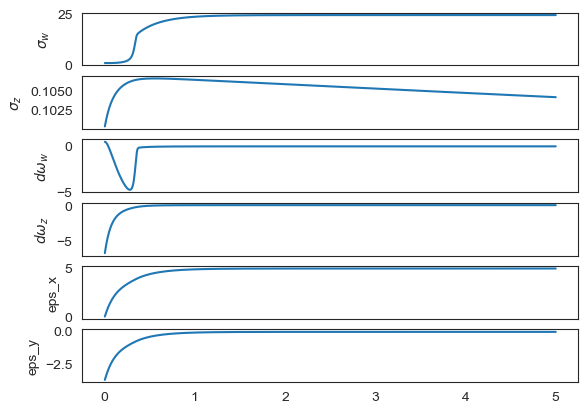

In [63]:
fig, axes = plt.subplots(6, 1, sharex='col');


axes[0].plot(t[1:],vSigma_w1[1:],label='sigmaw');
axes[0].set_ylabel('$\sigma_w$');
axes[1].plot(t[1:],vSigma_z1[1:],label='sigmaz');
axes[1].set_ylabel('$\sigma_z$');
axes[2].plot(t[1:],plot_dict1["dprec_w"],label='domegaw');
axes[2].set_ylabel('$d\omega_w$');
axes[3].plot(t[1:],plot_dict1["dprec_z"],label='domegaz');
axes[3].set_ylabel('$d\omega_z$');
axes[4].plot(t[1:],plot_dict1["eps_x"],label='domegaw');
axes[4].set_ylabel('eps_x');
axes[5].plot(t[1:],plot_dict1["eps_y"],label='domegaz');
axes[5].set_ylabel('eps_y');

fig, axes = plt.subplots(6, 1, sharex='col');


axes[0].plot(t[1:],vSigma_w2[1:],label='sigmaw2');
axes[0].plot(t[1:],vSigma_w3[1:],label='sigmaw3');
axes[0].set_ylabel('$\sigma_w$');
axes[1].plot(t[1:],vSigma_z2[1:],label='sigmaz2');
axes[1].plot(t[1:],vSigma_z3[1:],label='sigmaz3');
axes[1].set_ylabel('$\sigma_z$');
axes[2].plot(t[1:],plot_dict2["dprec_w"],label='domegaw2');
axes[2].plot(t[1:],plot_dict3["dprec_w"],label='domegaw3');
axes[2].set_ylabel('$d\omega_w$');
axes[3].plot(t[1:],plot_dict2["dprec_z"],label='domegaz2');
axes[3].plot(t[1:],plot_dict3["dprec_z"],label='domegaz3');
axes[3].set_ylabel('$d\omega_z$');
axes[4].plot(t[1:],plot_dict2["eps_x"],label='domegaw2');
axes[4].plot(t[1:],plot_dict3["eps_x"],label='domegaw3');
axes[4].set_ylabel('eps_x');
axes[5].plot(t[1:],plot_dict2["eps_y"],label='domegaz2');
axes[5].plot(t[1:],plot_dict3["eps_y"],label='domegaz3');
axes[5].set_ylabel('eps_y');
fig.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)



fig, axes = plt.subplots(6, 1, sharex='col');


axes[0].plot(t[1:],vSigma_w4[1:],label='sigmaw');
axes[0].set_ylabel('$\sigma_w$');
axes[1].plot(t[1:],vSigma_z4[1:],label='sigmaz');
axes[1].set_ylabel('$\sigma_z$');
axes[2].plot(t[1:],plot_dict4["dprec_w"],label='domegaw');
axes[2].set_ylabel('$d\omega_w$');
axes[3].plot(t[1:],plot_dict4["dprec_z"],label='domegaz');
axes[3].set_ylabel('$d\omega_z$');
axes[4].plot(t[1:],plot_dict4["eps_x"],label='domegaw');
axes[4].set_ylabel('eps_x');
axes[5].plot(t[1:],plot_dict4["eps_y"],label='domegaz');
axes[5].set_ylabel('eps_y');




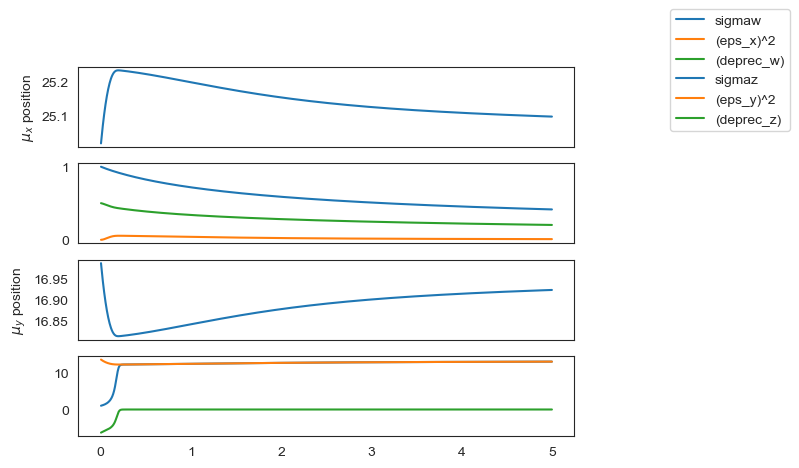

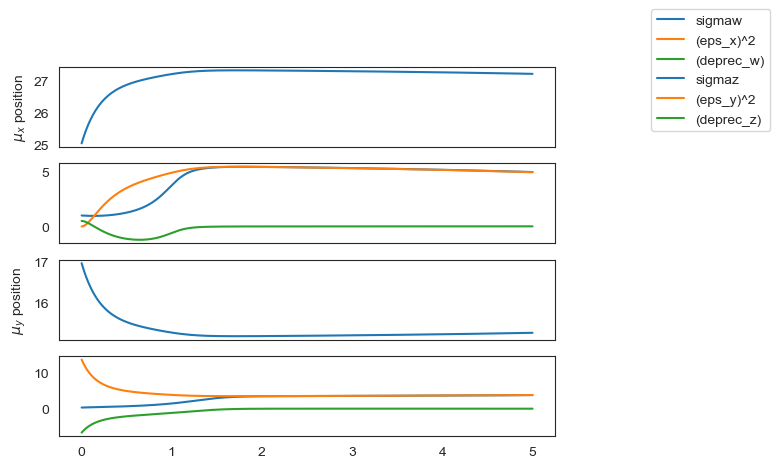

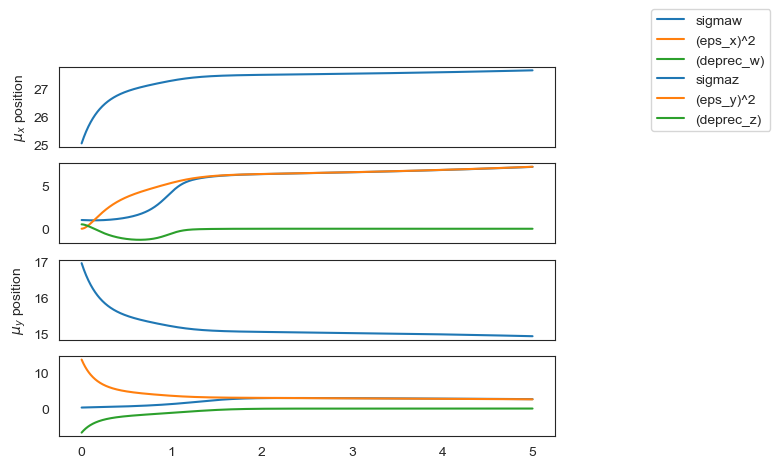

In [70]:
#1,1
fig, axes = plt.subplots(4, 1, sharex='col');
axes[0].set_ylabel('$\mu_x$ position');
axes[0].plot(t[1:],mu_x1[1:]);
axes[1].plot(t[1:],vSigma_w1[1:],label='sigmaw');
axes[1].plot(t[1:],eps_x1_squared,label='(eps_x)^2');
axes[1].plot(t[1:],plot_dict1["dprec_w"],label='(deprec_w)');
axes[2].set_ylabel('$\mu_y$ position');

axes[2].plot(t[1:],mu_y1[1:]);
axes[3].plot(t[1:],vSigma_z1[1:],label='sigmaz');
axes[3].plot(t[1:],eps_y1_squared,label='(eps_y)^2');
axes[3].plot(t[1:],plot_dict1["dprec_z"],label='(deprec_z)');

fig.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

# 1,0.302
fig, axes = plt.subplots(4, 1, sharex='col');
axes[0].set_ylabel('$\mu_x$ position');
axes[0].plot(t[1:],mu_x2[1:]);
axes[1].plot(t[1:],vSigma_w2[1:],label='sigmaw');
axes[1].plot(t[1:],eps_x2_squared,label='(eps_x)^2');
axes[1].plot(t[1:],plot_dict2["dprec_w"],label='(deprec_w)');
axes[2].set_ylabel('$\mu_y$ position');

axes[2].plot(t[1:],mu_y2[1:]);
axes[3].plot(t[1:],vSigma_z2[1:],label='sigmaz');
axes[3].plot(t[1:],eps_y2_squared,label='(eps_y)^2');
axes[3].plot(t[1:],plot_dict2["dprec_z"],label='(deprec_z)');

fig.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

# 1,0.301
fig, axes = plt.subplots(4, 1, sharex='col');
axes[0].set_ylabel('$\mu_x$ position');
axes[0].plot(t[1:],mu_x3[1:]);
axes[1].plot(t[1:],vSigma_w3[1:],label='sigmaw');
axes[1].plot(t[1:],eps_x3_squared,label='(eps_x)^2');
axes[1].plot(t[1:],plot_dict3["dprec_w"],label='(deprec_w)');
axes[2].set_ylabel('$\mu_y$ position');

axes[2].plot(t[1:],mu_y3[1:]);
axes[3].plot(t[1:],vSigma_z3[1:],label='sigmaz');
axes[3].plot(t[1:],eps_y3_squared,label='(eps_y)^2');
axes[3].plot(t[1:],plot_dict3["dprec_z"],label='(deprec_z)');

fig.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

# #1,0.1
# fig, axes = plt.subplots(4, 1, sharex='col');
# axes[0].set_ylabel('$\mu_x$ position');
# axes[0].plot(t[1:],mu_x4[1:]);
# axes[1].plot(t[1:],vSigma_w4[1:],label='sigmaw');
# axes[1].plot(t[1:],eps_x4_squared,label='(eps_x)^2');
# axes[1].plot(t[1:],plot_dict4["dprec_w"],label='(deprec_w)');
# axes[2].set_ylabel('$\mu_y$ position');

# axes[2].plot(t[1:],mu_y4[1:]);
# axes[3].plot(t[1:],vSigma_z4[1:],label='sigmaz');
# axes[3].plot(t[1:],eps_y4_squared,label='(eps_y)^2');
# axes[3].plot(t[1:],plot_dict4["dprec_z"],label='(deprec_z)');

# fig.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)




In [72]:
print('x')
print(eps_x2_squared[375])
print(vSigma_w2[375])
print(eps_x3_squared[375])
print(vSigma_w3[375])

print('y')
print(eps_y2_squared[375])
print(vSigma_z2[375])
print(eps_y3_squared[375])
print(vSigma_z3[375])


x
5.429187555889568
5.431732487225116
6.261072627896915
6.24559715987061
y
3.481602561001259
3.405499651464734
3.0134301774414176
2.8732026245546387
